# Download and Process MapBiomas Data
This notebook downloads MapBiomas LULC and irrigation data using Google Earth Engine (Souza et al. (2020) – Reconstructing Three Decades of Land Use and Land Cover Changes in Brazilian Biomes with Landsat Archive and Earth Engine – Remote Sensing, Volume 12, Issue 17, 10.3390/rs12172735.)

In [32]:
#Download MapBiomas data from Google Earth Engine
!pip -q install earthengine-api geemap

import ee, geemap
ee.Authenticate()
ee.Initialize()

In [14]:
#import shapefile
maranhao = ee.FeatureCollection("projects/ee-emilychristinedecker/assets/maranhao_boundary")
maranhao_geom = maranhao.geometry()

In [ ]:
#Define functions for getting data and assets of interest
import ee, geemap
import re

def build_year_band_lookup(asset_id):
    """
    Returns a dict: {year:int -> band_name:str} by scanning band names for YYYY tokens.
    Works for MapBiomas images that store each year as a separate band.
    """
    img = ee.Image(asset_id)
    band_names = img.bandNames().getInfo()  # one-time client-side call

    lookup = {}
    for b in band_names:
        m = re.search(r"(19|20)\d{2}", b)
        if m:
            lookup[int(m.group(0))] = b
    return lookup, img

def resample_categorical_to_250m(img, crs="EPSG:4326", scale=250):
    """
    Mode aggregation for categorical maps (LULC, irrigation classes).
    """
    return (img
            .reduceResolution(reducer=ee.Reducer.mode(), maxPixels=2048)
            .reproject(crs=crs, scale=scale))

ASSET_LULC = "projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_integration_v2"
ASSET_IRR  = "projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_agriculture_irrigation_systems_v3"


In [ ]:
#Downloads data to google drive
years = range(2000, 2025)
drive_folder = "mapbiomas"
crs = "EPSG:4326"
scale = 250

def export_to_drive(image, description, filename_prefix):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=drive_folder,
        fileNamePrefix=filename_prefix,
        region=maranhao_geom,
        scale=scale,
        crs=crs,
        maxPixels=1e13
    )
    task.start()
    return task

tasks = []

for y in years:
    #LULC
    if y in lulc_lookup:
        lulc_y = ee.Image(lulc_img).select(lulc_lookup[y]).clip(maranhao_geom)
        lulc_250 = resample_categorical_to_250m(lulc_y, crs=crs, scale=scale)
        tasks.append(export_to_drive(
            lulc_250,
            description=f"MB_LULC_{y}_MA_250m",
            filename_prefix=f"mapbiomas_lulc_{y}_maranhao_250m"
        ))
    else:
        print(f"[WARN] LULC band not found for {y}")

    #Irrigation
    if y in irr_lookup:
        irr_y = ee.Image(irr_img).select(irr_lookup[y]).clip(maranhao_geom)
        irr_250 = resample_categorical_to_250m(irr_y, crs=crs, scale=scale)
        tasks.append(export_to_drive(
            irr_250,
            description=f"MB_IRR_{y}_MA_250m",
            filename_prefix=f"mapbiomas_irrigation_{y}_maranhao_250m"
        ))
    else:
        print(f"[WARN] Irrigation band not found for {y}")

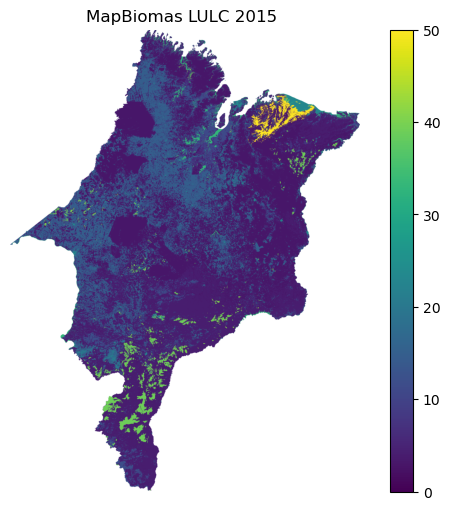

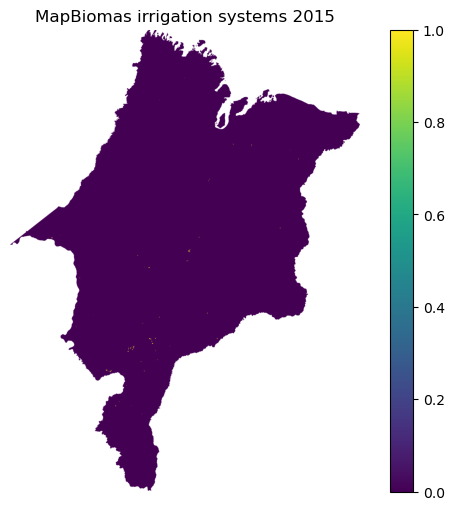

In [30]:
#Exploratory analysis - create maps of LULC and irrigation for year of interest
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.features import geometry_mask

maranhao = gpd.read_file("maranhao_boundary/maranhao_boundary.shp")

y = 2015
fp = "mapbiomas"
lulc_path = f"{fp}/mapbiomas_lulc_{y}_maranhao_250m.tif"
irr_path  = f"{fp}/mapbiomas_irrigation_{y}_maranhao_250m.tif"

def show(path, title, boundary_gdf):
    with rasterio.open(path) as ds:
        a = ds.read(1).astype("float32")
        mask = geometry_mask(
            boundary_gdf.geometry,
            transform=ds.transform,
            invert=True,
            out_shape=a.shape
        )
        a[~mask] = np.nan

    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")
    plt.figure(figsize=(8,6))
    plt.imshow(a, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.colorbar()
    plt.show()


show(lulc_path, f"MapBiomas LULC {y} ", maranhao)
show(irr_path,  f"MapBiomas irrigation systems {y}", maranhao)


In [ ]:
#Creat resampled MapBiomas rasters that match NDVI data for integration
import rasterio

ndvi_ref_fp = "maranhao_ndvi_anomaly_rasters/ndvi_rainy_anomaly_2012.tif"

with rasterio.open(ndvi_ref_fp) as ref:
    REF_CRS = ref.crs
    REF_TRANSFORM = ref.transform
    REF_SHAPE = (ref.height, ref.width)
    REF_PROFILE = ref.profile.copy()

from rasterio.warp import reproject, Resampling
import numpy as np
import os

def resample_mapbiomas_to_ndvi(
    mapbiomas_fp,
    out_fp,
    ref_crs,
    ref_transform,
    ref_shape,
    ref_profile
):
    with rasterio.open(mapbiomas_fp) as src:
        src_data = src.read(1)

        dest = np.empty(ref_shape, dtype=src_data.dtype)

        reproject(
            source=src_data,
            destination=dest,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.nearest  # REQUIRED
        )

        profile = ref_profile.copy()
        profile.update(
            dtype=src_data.dtype,
            count=1,
            nodata=src.nodata
        )

        with rasterio.open(out_fp, "w", **profile) as dst:
            dst.write(dest, 1)
            
years = range(2000, 2025)

mapbiomas_dir = "mapbiomas"
out_dir = "mapbiomas_resampled"
os.makedirs(out_dir, exist_ok=True)

for y in years:
    in_fp = f"{mapbiomas_dir}/mapbiomas_irrigation_{y}_maranhao_250m.tif"
    out_fp = f"{out_dir}/mapbiomas_irrigation_{y}_resampled.tif"

    resample_mapbiomas_to_ndvi(
        mapbiomas_fp=in_fp,
        out_fp=out_fp,
        ref_crs=REF_CRS,
        ref_transform=REF_TRANSFORM,
        ref_shape=REF_SHAPE,
        ref_profile=REF_PROFILE
    )
